In [1]:
using CUDAdrv; CUDAdrv.name(CuDevice(0))

"GeForce GTX 1080"

┌ Info: Recompiling stale cache file /home/deepkapha/.julia/compiled/v1.0/CuArrays/7YFE0.ji for CuArrays [3a865a2d-5b23-5a0f-bc46-62713ec82fae]
└ @ Base loading.jl:1190
┌ Info: Building the CUDAnative run-time library for your sm_61 device, this might take a while...
└ @ CUDAnative /home/deepkapha/.julia/packages/CUDAnative/Phjco/src/compiler/rtlib.jl:188


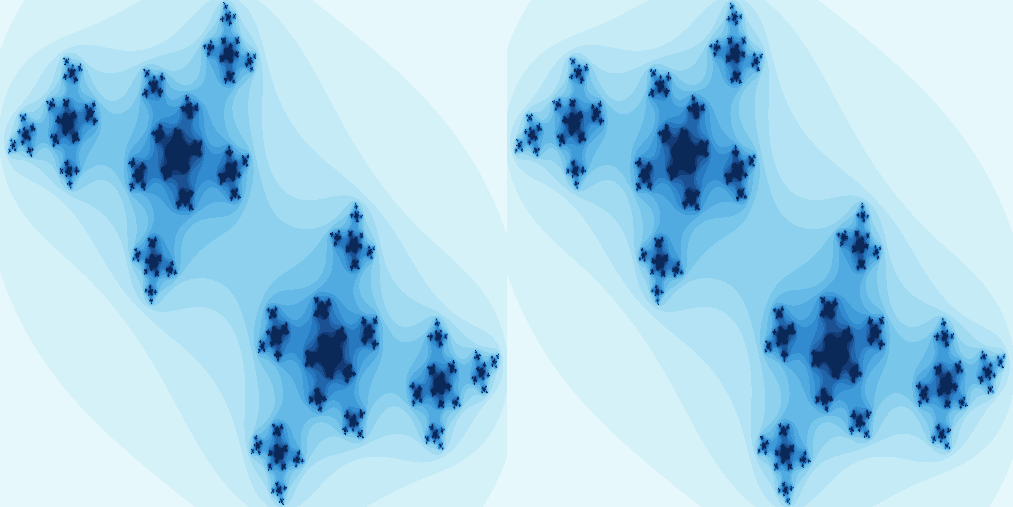

┌ Info: For better quality inline display of large images or thumbnails, load the Images package.
└ @ ImageShow /home/deepkapha/.julia/packages/ImageShow/9kpaq/src/showmime.jl:128


In [2]:
using CuArrays, FileIO, Colors, GPUArrays, BenchmarkTools, ImageShow
using CuArrays: CuArray
"""
The function calculating the Julia set
"""
function juliaset(z0, maxiter)
    c = ComplexF32(-0.5, 0.75)
    z = z0
    for i in 1:maxiter
        abs2(z) > 4f0 && return (i - 1) % UInt8
        z = z * z + c
    end
    return maxiter % UInt8 # % is used to convert without overflow check
end
range = 100:50:2^12
cutimes, jltimes = Float64[], Float64[]
function run_bench(in, out)
  # use dot syntax to apply `juliaset` to each elemt of q_converted 
  # and write the output to result
  out .= juliaset.(in, 16)
  # all calls to the GPU are scheduled asynchronous, 
  # so we need to synchronize
  GPUArrays.synchronize(out)
end
# store a reference to the last results for plotting
last_jl, last_cu = nothing, nothing
for N in range
  w, h = N, N
  q = [ComplexF32(r, i) for i=1:-(2.0/w):-1, r=-1.5:(3.0/h):1.5]
  for (times, Typ) in ((cutimes, CuArray), (jltimes, Array))
    # convert to Array or CuArray - moving the calculation to CPU/GPU
    q_converted = Typ(q)
    result = Typ(zeros(UInt8, size(q)))
    for i in 1:10 # 5 samples per size
      # benchmarking macro, all variables need to be prefixed with $
      t = Base.@elapsed begin
				run_bench(q_converted, result)
      end
      global last_jl, last_cu # we're in local scope
      if result isa CuArray
        last_cu = result
      else
      	last_jl = result
      end
      push!(times, t)
    end
  end
end

cu_jl = hcat(Array(last_cu), last_jl)
cmap = colormap("Blues", 16 + 1)
color_lookup(val, cmap) = cmap[val + 1]
color_lookup.(cu_jl, (cmap,))

In [3]:
using Plots; plotly()
x = repeat(range, inner = 10)
speedup = jltimes ./ cutimes
Plots.scatter(
  log2.(x), [speedup, fill(1.0, length(speedup))], 
  label = ["cuda" "cpu"], markersize = 2, markerstrokewidth = 0,
  legend = :right, xlabel = "2^N", ylabel = "speedup"
)

┌ Info: Recompiling stale cache file /home/deepkapha/.julia/compiled/v1.0/Plots/ld3vC.ji for Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1190
┌ Info: For saving to png with the Plotly backend ORCA has to be installed.
└ @ Plots /home/deepkapha/.julia/packages/Plots/cc8wh/src/backends.jl:363


<!DOCTYPE html>
 
 
 Plots.jl

### Memory

GPUs have their own memory space with video memory (VRAM), different caches, and registers. Whatever you do, any Julia object must get transferred to the GPU before you can work with it. Not all types in Julia work on the GPU.

In [4]:
struct Test # an immutable struct
# that only contains other immutable, which makes 
# isbitstype(Test) == true
	x::Float32 
end

# the isbits property is important, since those types can be used
# without constraints on the GPU!
@assert isbitstype(Test) == true
x = (2, 2)
isa(x, Tuple{Int, Int}) # tuples are also immutable
mutable struct Test2 #-> mutable, isbits(Test2) == false
	x::Float32
end
struct Test3
	# contains a heap allocation/ reference, not isbits
	x::Vector{Float32}
	y::Test2 # Test2 is mutable and also heap allocated / a reference
end
Vector{Test} # <-  An Array with isbits elements is contigious in memory
Vector{Test2} # <- An Array with mutable elements is basically an array of heap pointers. Since it just contains cpu heap pointers, it won't work on the GPU.

Array{Test2,1}

All those Julia types behave differently when transferred to the GPU or when created on the GPU. You can use the following table to get an overview of what to expect:

$$
\tiny
\left[
\begin{array}{ccccccc}
\text{} & \text{ isbits type} & \text{immutable type} & \text{mutable type} & \text{julia array} & \text{gpu array} & \text{(device) local memory} \\
\text{location of creation} & \text{} & \text{} & \text{} & \text{} & \text{} & \text{} \\
\text{on CPU} & \text{yes, copy} & \text{no ptrs, copy} & \text{copy} & \text{no} & \text{by reference} & \text{no} \\
\text{on GPU} & \text{yes} & \text{may contain device ptr} & \text{no (on 0.7 if elimated)} & \text{no} & \text{no} & \text{yes} \\
\end{array}
\right]
$$

Location of creation describes if the object was created on the CPU and then transferred to the GPU kernel, or if it was created on the GPU inside the kernel. The table shows if it is possible to create an instance of a type, and for the transfer from CPU to GPU, the table also indicates if the object gets copied or passed by reference.

### Garbage Collection

A big difference when working with the GPU is that there is no garbage collector (GC) on the GPU. This is gladly not a big issue, since the kind of high performance kernel one writes for the GPU shouldn't create any GC-tracked memory to begin with.

As an alternative to heap allocated arrays inside the kernel, you can use GPUArrays. The GPUArray constructor will create GPU buffers and transfer the data to VRAM. If you call Array(gpu_array) the array will get transferred back to RAM, represented as a normal Julia Array. The Julia handle to those GPU arrays is tracked by Julia's GC and if it's not used anymore, the GPU memory will be freed.

Consequently, one can only use stack allocation on the device, and for the rest pre-allocated GPU buffers are used. As transfers are expensive, it is common to reuse and pre-allocate as much as possible when programming the GPU.

### The GPUArray Constructors

In [7]:
using CuArrays, LinearAlgebra
using CuArrays.CURAND

# GPU Arrays can be constructed from all Julia arrays containing isbits types!
A1D = cu([1, 2, 3]) # cl for CLArrays
A1D = CuArrays.fill(0, 100) # CLArray for CLArrays
# Float32 array - Float32 is usually preferred and can be up to 30x faster on most GPUs than Float64
diagonal_matrix = CuArray{Float32}(I, 100, 100)
filled = CuArrays.fill(77f0, (4, 4, 4)) # 3D array filled with Float32 77
randy = CuArrays.rand(42, 42) # random numbers generated on the GPU
# The array constructor also accepts isbits iterators with a known size
# Note, that since you can also pass isbits types to a gpu kernel directly, in most cases you won't need to materialize them as an gpu array
from_iter = CuArray(1:10)
# let's create a point type to further illustrate what can be done:
struct Point
    x::Float32
    y::Float32
end
Base.convert(::Type{Point}, x::NTuple{2, Any}) = Point(x[1], x[2])
# because we defined the above convert from a tuple to a point
# [Point(2, 2)] can be written as Point[(2,2)] since all array 
# elements will get converted to Point
custom_types = cu(Point[(1, 2), (4, 3), (2, 2)])
typeof(custom_types)

CuArray{Point,1,Nothing}

### Array Operations

Lots of operations are already defined. Most importantly, GPUArrays support Julia's fusing dot broadcasting notation. This notation allows you to apply a function to each element of an array, and create a new array out of the return values of f. This functionality is usually referred to as a map. The broadcast refers to the fact that arrays with different shapes get broadcasted to the same shape.

In [8]:
x = zeros(4, 4) # 4x4 array of zeros
y = zeros(4) # 4 element array
z = 2 # a scalar
# y's 1st dimension gets repeated for the 2nd dimension in x
# and the scalar z get's repeated for all dimensions
# the below is equal to `broadcast(+, broadcast(+, xx, y), z)`
x .+ y .+ z

4×4 Array{Float64,2}:
 2.0  2.0  2.0  2.0
 2.0  2.0  2.0  2.0
 2.0  2.0  2.0  2.0
 2.0  2.0  2.0  2.0

The fusion happens because the Julia compiler will rewrite this expression into one lazy broadcast call that gets the call tree passed, which then can fuse the whole call tree into one function before looping over the array.

If you want a more thorough and interactive explanation of how broadcasting works, you can have a look at this great guide: julia.guide/broadcasting

This means any Julia function that runs without allocating heap memory (only creating isbits types), can be applied to each element of a GPUArray and multiple dot calls will get fused into one kernel call. As kernel call latency is high, this fusion is a very important optimization.

In [9]:
using CuArrays
A = cu([1, 2, 3])
B = cu([1, 2, 3])
C = CuArrays.rand(3)
result = A .+ B .- C
test(a::T) where T = a * convert(T, 2) # convert to same type as `a`

# inplace broadcast, writes directly into `result`
result .= test.(A) # custom function work

# The cool thing is that this composes well with custom types and custom functions.
# Let's go back to our Point type and define addition for it
Base.:(+)(p1::Point, p2::Point) = Point(p1.x + p2.x, p1.y + p2.y)

# now this works:
custom_types = cu(Point[(1, 2), (4, 3), (2, 2)])

# This particular example also shows the power of broadcasting: 
# Non array types are broadcasted and repeated for the whole length
result = custom_types .+ Ref(Point(2, 2))

# So the above is equal to (minus all the allocations):
# this allocates a new array on the gpu, which we can avoid with the above broadcast
broadcasted = fill(CuArray, Point(2, 2), (3,))

result == custom_types .+ broadcasted

true

## MNIST



In [11]:
using Flux, Flux.Data.MNIST, Statistics
using Flux: onehotbatch, onecold, crossentropy, throttle, params
using Base.Iterators: repeated, partition
using CuArrays

# Classify MNIST digits with a convolutional network

imgs = MNIST.images()

labels = onehotbatch(MNIST.labels(), 0:9)

# Partition into batches of size 1,000
train = [(cat(float.(imgs[i])..., dims = 4), labels[:,i])
         for i in partition(1:60_000, 1000)]

use_gpu = true # helper to easily switch between gpu/cpu

todevice(x) = use_gpu ? gpu(x) : x

train = todevice.(train)

# Prepare test set (first 1,000 images)
tX = cat(float.(MNIST.images(:test)[1:1000])..., dims = 4) |> todevice
tY = onehotbatch(MNIST.labels(:test)[1:1000], 0:9) |> todevice

m = todevice(Chain(
  Conv((2,2), 1=>16, relu),
  MaxPool((2, 2)),
  Conv((2,2), 16=>8, relu),
  MaxPool((2, 2)),
  x -> reshape(x, :, size(x, 4)),
  Dense(288, 10), softmax
))

loss(x, y) = crossentropy(m(x), y)

loss (generic function with 1 method)

In [ ]:
# train
Flux.train!(loss, params(m), train, ADAM())

In [ ]:
using Colors, FileIO, ImageShow
N = 7
img = tX[:, :, 1:1, N:N]
println("Predicted: ", Flux.onecold(m(gpu(img))) .- 1)

save("results/test.png", collect(tX[:, :, 1, N]))

Just by converting the arrays to GPUArrays (with gpu(array)) we were able to move the entire computation to the GPU and get a pretty nice speed improvement. This is thanks to Julia's sophisticated AbstractArray infrastructure, into which GPUArrays seamlessly integrates. Subsequently, if you leave out the conversion to a GPUArray, the code will also run with normal Julia arrays – but then of course on the CPU. You can try this out by changing use_gpu = true to use_gpu = false and rerun the initialization and training cells. Comparing GPU and CPU, I get 975 seconds for a CPU run and 29 seconds for the GPU - which is a nice speed-up of ~33x.

Another nice property to look at is that GPUArrays never had to implement automatic differentiation explicitly to support the backward pass of the neuronal network efficiently. This is because Julia's automatic differentiation libraries work for arbitrary functions and emit code that can run efficiently on the GPU. This helps a lot to get Flux working on the GPU with minimal developer effort - and makes Flux GPU support work efficiently even for user defined functions. That this works out of the box without coordination between GPUArrays + Flux is a pretty unique property of Julia, which is explained in great detail in: Why Numba and Cython are no substitute for Julia

## Writing GPU Kernels

One can get pretty far by just using the generic abstract array interface of GPUArrays without ever writing any GPU kernels. However, at some point one might need to implement an algorithm that needs to run on the GPU and can't be expressed by a combination of generic array algorithms!

The nice thing is that GPUArrays takes away quite a bit of work with a layered approach that lets you start off with high level code, but allows you to pretty much write low-level kernels similarly to what one would find in most OpenCL/CUDA examples. It also allows you to execute kernels both on OpenCL or CUDA devices, abstracting away any differences in those frameworks.

The function that makes this possible is named gpu_call. It can be called as gpu_call(kernel, A::GPUArray, args) and will call kernel with the arguments (state, args...) on the GPU. State is a backend specific object to implement functionality like getting the thread index. A GPUArray needs to get passed as the second argument to dispatch to the correct backend and supply the defaults for the launch parameters.

In [22]:
using GPUArrays, CuArrays
# Overloading the Julia Base map! function for GPUArrays
function Base.map!(f::Function, A::GPUArray, B::GPUArray)
    # our function that will run on the gpu
    function kernel(state, f, A, B)
        # If launch parameters aren't specified, linear_index gets the index
        # into the Array passed as second argument to gpu_call (`A`)
        i = linear_index(state)
    		if i <= length(A)
          @inbounds A[i] = f(B[i])
        end
        return
    end
    # call kernel on the gpu
    gpu_call(kernel, A, (f, A, B))
end

Let's try to figure out what this is doing! In simple terms, this will call the Julia function kernel **length(A)** times in parallel on the GPU. Each parallel invocation of kernel has a thread index, which we can use to safely index into the arrays A and B. If we calculated our own indices instead of using linear_index, we'd need to make sure that we don't have multiple threads reading and writing to the same array locations. So, if we wrote this in pure Julia with threads, an equivalent version would look like this:

In [23]:
using BenchmarkTools
function threadded_map!(f::Function, A::Array, B::Array)
    Threads.@threads for i in 1:length(A)
        A[i] = f(B[i])
    end
  A
end
x, y = rand(10^7), rand(10^7)
kernel(y) = (y / 33f0) * (732.f0/y)
# on the cpu without threads:
single_t = @belapsed map!($kernel, $x, $y)

# "on the CPU with 4 threads (2 real cores):
thread_t = @belapsed threadded_map!($kernel, $x, $y)

# on the GPU:
xgpu, ygpu = cu(x), cu(y)
gpu_t = @belapsed begin
  map!($kernel, $xgpu, $ygpu)
  GPUArrays.synchronize($xgpu)
end
times = [single_t, thread_t, gpu_t]
speedup = maximum(times) ./ times
println("speedup: $speedup")
bar(["1 core", "2 cores", "gpu"], speedup, legend = false, fillcolor = :grey, ylabel = "speedup")

speedup: [1.00554, 1.0, 64.556]


<!DOCTYPE html>
 
 
 Plots.jl

Because the function isn't doing a lot of work, we don't see perfect scaling, but the threaded and GPU version still give us a nice speed-up. 

The GPU is a bit more complex than what the thread example allows us to show, since the hardware threads are laid out in blocks of threads – gpu_call abstracts that away in the simple version, but it can also be used with more complex launch configurations:m

In [24]:
using CuArrays

threads = (2, 2)
blocks = (2, 2)
T = fill(CuArray, (0, 0), (4, 4))
B = fill(CuArray, (0, 0), (4, 4))
gpu_call(T, (B, T), (blocks, threads)) do state, A, B
  # those names pretty much refer to the cuda names
    b = (blockidx_x(state), blockidx_y(state))
    bdim = (blockdim_x(state), blockdim_y(state))
    t = (threadidx_x(state), threadidx_y(state))
    idx = (bdim .* (b .- 1)) .+ t
    A[idx...] = b
    B[idx...] = t
    return
end
println("Threads index: \n", T)
println("Block index: \n", B)

Threads index: 
Tuple{Int64,Int64}[(1, 1) (1, 2) (1, 1) (1, 2); (2, 1) (2, 2) (2, 1) (2, 2); (1, 1) (1, 2) (1, 1) (1, 2); (2, 1) (2, 2) (2, 1) (2, 2)]
Block index: 
Tuple{Int64,Int64}[(1, 1) (1, 1) (1, 2) (1, 2); (1, 1) (1, 1) (1, 2) (1, 2); (2, 1) (2, 1) (2, 2) (2, 2); (2, 1) (2, 1) (2, 2) (2, 2)]


In the above example you can see the iteration order of a more complex launch configuration. Figuring out the right iteration + launch configuration is crucial to achieve state of the art GPU performance – but won't be part of this simple introduction. There are plenty of GPU tutorials for CUDA and OpenCL which explain this in great detail and those principles are identical when programming the GPU in Julia.

### Conclusion

Julia has come a long way to bring composable high-level programming to the high performance world. Now it's time to do the same for the GPU.

The hope is that Julia lowers the bar for people to start programming on GPUs, and that we can grow an extendable platform for open source GPU computing. The first success story, of automatic differentiation working out of the box via Julia packages that haven't even been written for the GPU, gives a lot of reason to believe in the success of Julia's extendable and generic design in the domain of GPU computing.